
<br>

<div style ="width: 100%;">
<table style ="width: 100%;float:center;">
<tr>

</tr>
    
<tr>
        
<td>
<div style="font-size: 21px;Margin-left:-10px;">
<b>TP2: Interação e Concorrência<b>
</div>
    <br>
    <br>
<div style="font-size: 16px;">
    
Realizado por:

Carlos Ferreira a87953

Daniel Ribeiro a87994
</div>
</td>
<td >
<div style="display:inline-block; float:right;Margin-right:0px;Margin-top:20px;">
<img src="https://www.ecum.uminho.pt/SiteAssets/ECUM-PT.png" width="260" height="120">
<div>
</td>
</tr>
</table>
</div>
    

# Problema

Each group of students has a number assigned, N. Now, you have to use a quantum algorithm to find s
<br>
$  \quad \quad \quad s = N \ mod \ 8$
<br>
in an unsorted list.

 ## 1. Division of the algorithm into sections; Utilisation of the state vector simulator to explain each step (special attention to the oracle);


In [1]:
from qiskit import *
from qiskit.tools.visualization import plot_histogram, plot_state_city, plot_state_hinton,plot_state_paulivec
from qiskit.providers.ibmq import least_busy
import qiskit.tools.jupyter
import math
from qiskit.providers.aer.noise import NoiseModel
import matplotlib.pyplot as plt
%matplotlib inline

<img src="https://scx2.b-cdn.net/gfx/news/2018/groversearch.jpg" alt="Note: In order for images to show up in this jupyter notebook you need to select File => Trusted Notebook" width="800 px" align="center">

1.1. Começamos por determinar o número de quibit's necessários para o algoritmo, neste caso vamos precisar de 3.

In [41]:
b = bin(7)[2:]
numQubits = len(b)
numQubits

3

1.2. De seguida vamos iniciar o circuito criando super posição em todos os qubits.

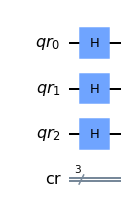

In [42]:
qr = QuantumRegister (numQubits , "qr")
cr = ClassicalRegister (numQubits , "cr")
circuito_v1 = QuantumCircuit (qr ,cr)


# inicialização

for i in range(numQubits):
    circuito_v1.h(qr[i])
    
circuito_v1.draw(output='mpl')

1.2.1. Podemos ver o state vector 

$ H.| 0 \rangle \otimes  H.| 0 \rangle \otimes  H.| 0 \rangle =  \begin{bmatrix}\frac{1}{(\sqrt{2})^3}\\\frac{1}{(\sqrt{2})^3}\\\frac{1}{(\sqrt{2})^3}\\\frac{1}{(\sqrt{2})^3}\\\frac{1}{(\sqrt{2})^3}\\\frac{1}{(\sqrt{2})^3}\\\frac{1}{(\sqrt{2})^3}\\\frac{1}{(\sqrt{2})^3}\end{bmatrix}$

In [43]:
backend_state = Aer.get_backend('statevector_simulator')
result = execute(circuito_v1, backend_state).result()
r  = result.get_statevector(circuito_v1)
print(r)

[0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j
 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j 0.35355339+0.j]


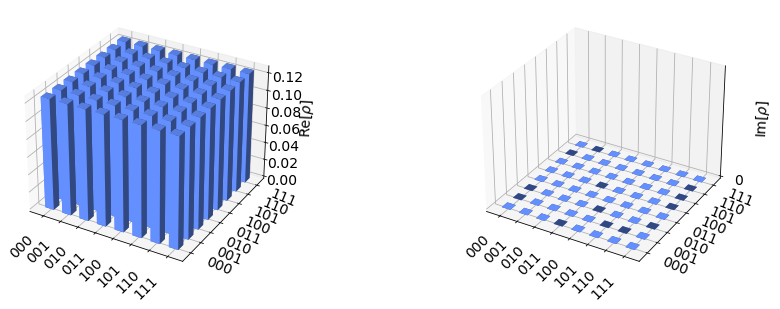

In [44]:
plot_state_city(r)

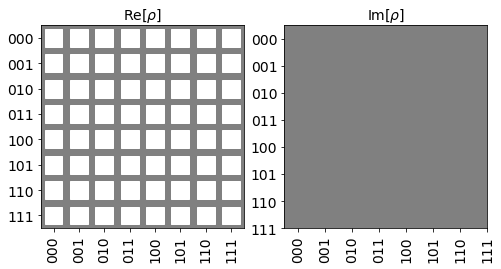

In [45]:
plot_state_hinton(r)

1.3. 
<br>
Visto sermos o grupo 9, o número que pretendemos encontrar é o 1 (9 % 8 = 1)
 <br>
 Para isto começamos por colocar X gates nos quibit's que são o 0 do número neste caso vamos colocar nos quibit's 1 e 2 
 <br>
 pois 1 = 001

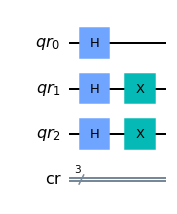

In [46]:
circuito_v1.x([1,2])
circuito_v1.draw(output='mpl')

1.4.
<br>
De seguida vamos implementar o nosso oraculo, basicamente o estado marcado vai rodar 𝜋 radianos (fica com a polaridade invertida ) e a sua amplitude probabilísta será negativa, enquanto as outras amplitudes não mudam.
<br>
Para obter esta rotação usamos um controlled-Z gate que é implementado com um Hadamard seguido de um CCX e outro Hadamard

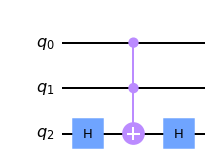

In [47]:
oraculo = QuantumCircuit (numQubits , name = "oraculo")

oraculo.h(2)
oraculo.ccx(0,1,2)
oraculo.h(2)

oraculo.to_gate()
oraculo.draw(output='mpl')

1.5.
<br>
Com o oraculo implementado vamos incluir-lo de seguida no circuito, também incluimos novamente 2 gates X nos quibit's 1 e 2 e uma barreira para melhor visualização.
<br>

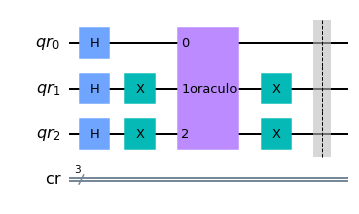

In [48]:
circuito_v1.append (oraculo , [0,1,2])
circuito_v1.x([1,2])
circuito_v1.barrier()
circuito_v1.draw(output='mpl')

1.6.
<br>
Como era esperado o valor que queremos encontrar está com a polaridade invertida podemos confirmar pelo state vector:
(valor negativo para o |001>)

In [49]:
result = execute(circuito_v1, backend_state).result()
r  = result.get_statevector(circuito_v1)
print(r)

[ 0.35355339+0.j -0.35355339+0.j  0.35355339+0.j  0.35355339+0.j
  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j  0.35355339+0.j]


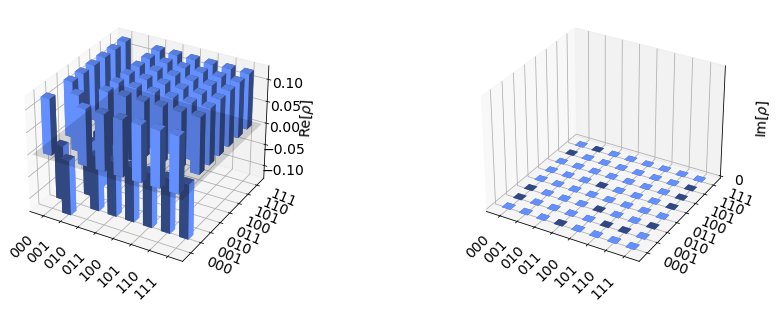

In [50]:
plot_state_city(r)

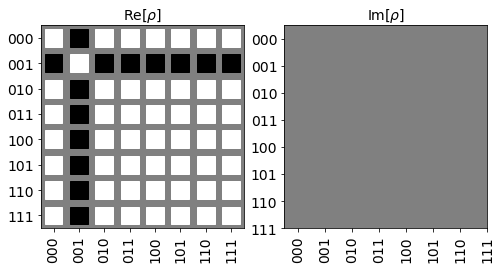

In [51]:
plot_state_hinton(r)

1.7. Amplitude Amplification


<br>
Finalmente implementamos o difusor, este vai aumentar a amplitude probabilísta do número que queremos procurar (|001>) e voltar a inverter-lo para uma polaridade positiva, reduzindo também todas as outras amplitudes.
<br>
<br>
Para o implementar começamos por colocar um Hadamard em todos os quibit's, seguido de uma gate X em todos os quibit's, após isto um controlled-Z gate que é implementado com um Hadamard seguido de um CCX e outro Hadamard e mais uma vez uma gate X em todos os quibit's, e for fim Hadamard em todos os qubits.

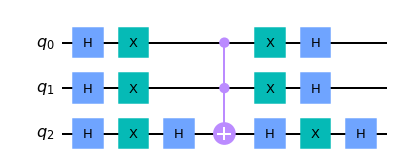

In [52]:
difusor = QuantumCircuit ( numQubits , name = "difusor")
difusor.h([0,1,2])
difusor.x([0,1,2])

difusor.h(2)
difusor.ccx(0,1,2)
difusor.h(2)

difusor.x([0,1,2])
difusor.h([0,1,2])

difusor.to_gate()
difusor.draw(output='mpl')

1.8.
<br>
Com ele implementado vamos então adicionar-lo ao circuito.

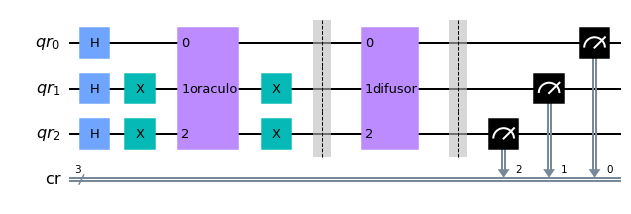

In [53]:
circuito_v1.append(difusor,[0,1,2])
circuito_v1.barrier()
circuito_v1.measure(qr[2],cr[2])
circuito_v1.measure(qr[1],cr[1])
circuito_v1.measure(qr[0],cr[0])
circuito_v1.draw(output='mpl')


1.9.
<br>
Após executar-mos uma vez conseguimos ver que obtemos uma grande probabilidade de o número que queremos procurar estar na lista.

In [54]:
result = execute(circuito_v1, backend_state).result()
r  = result.get_statevector(circuito_v1)
print(r)

[ 0.+0.00000000e+00j -0.+0.00000000e+00j  0.+0.00000000e+00j
 -1.-2.22044605e-16j -0.+0.00000000e+00j -0.+0.00000000e+00j
 -0.+0.00000000e+00j -0.+0.00000000e+00j]


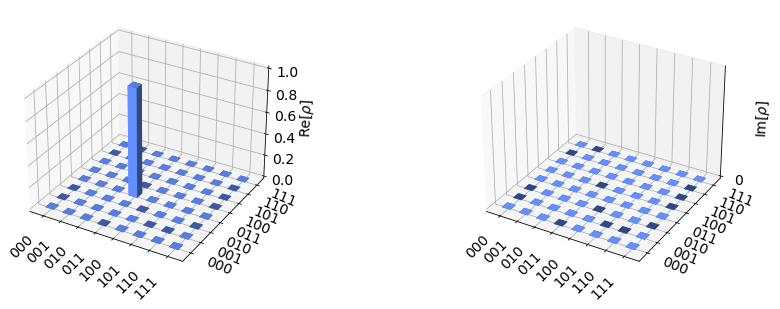

In [55]:
plot_state_city(r)

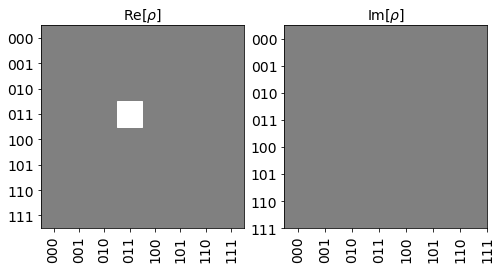

In [56]:
plot_state_hinton(r)

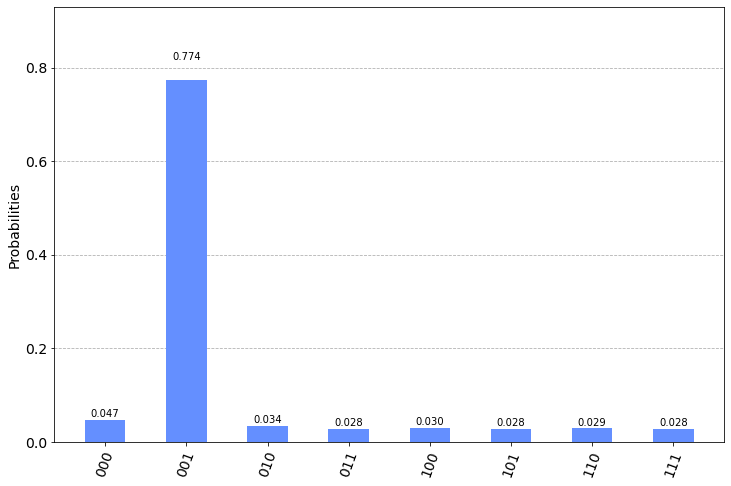

In [57]:
backend = Aer.get_backend("qasm_simulator")
shots=1024
result = execute(circuito_v1, backend, shots=shots).result()
counts_sim_v1 = result.get_counts(circuito_v1)
plot_histogram(counts_sim_v1,figsize = (12,8))

1.10.
<br>
Agora vamos testar para 2 execuções que é o ideal para uma lista de 8 elementos pois o algoritmo de grover corre em Ω(√N) que neste caso é Ω(√8) = 2 
<br>
Para isso é só repetir o circuito mais uma vez podemos mesmo utilizar um "ciclo for" para o desejado.

2


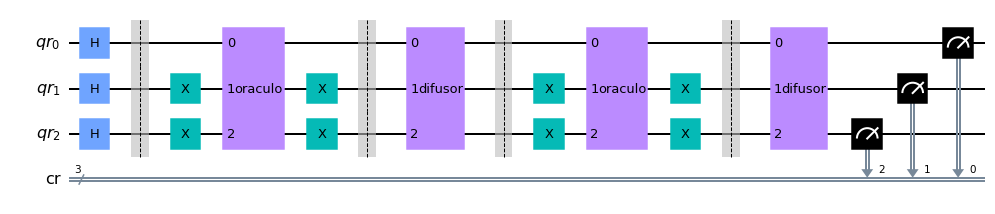

In [58]:
N = 9 % 8
numIteracoes = math.floor(math.sqrt(8))

print(numIteracoes)

qr = QuantumRegister (numQubits , "qr")
cr = ClassicalRegister (numQubits , "cr")
circuito = QuantumCircuit (qr ,cr)

circuito.h([0,1,2])

for i in range (numIteracoes):
    
    circuito.barrier()

    circuito.x([1,2])
    circuito.append(oraculo , [0,1,2])
    circuito.x([1,2])

    circuito.barrier()

    circuito.append(difusor , [0,1,2])



circuito.measure(qr[2],cr[2])
circuito.measure(qr[1],cr[1])
circuito.measure(qr[0],cr[0])

circuito.draw (output = "mpl")

1.11.
<br>
Acabamos assim com uma grande probabilidade de o número estar na lista. Como podemos observar:

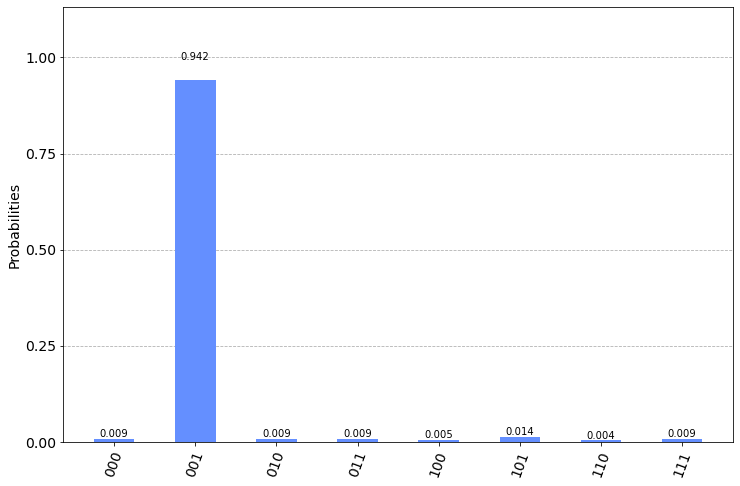

In [59]:
backend = Aer.get_backend("qasm_simulator")
shots = 1024
result = execute(circuito, backend, shots=shots).result()
counts_sim = result.get_counts(circuito)
plot_histogram(counts_sim,figsize = (12,8))

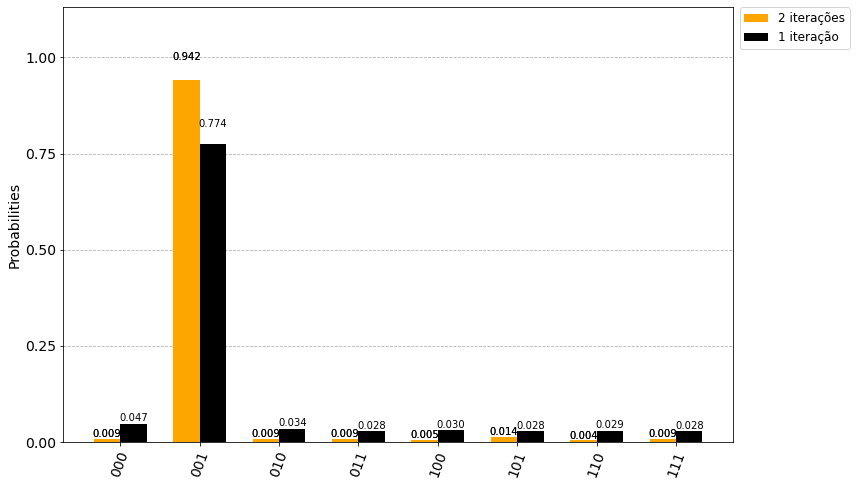

In [60]:
plot_histogram([counts_sim,counts_sim_v1], legend= ['2 iterações','1 iteração'], color=['orange', 'black'],figsize = (12,8))

 ## 2. Application of noise simulator to predict the best optimisation;


2.1
<br>
Definir o computador a usar

In [61]:
provider = IBMQ.load_account()
backends_list = provider.backends( simulator=False, open_pulse=False)
provider.backends()

ibmqfactory.load_account:WARNING:2021-06-06 23:52:59,149: Credentials are already in use. The existing account in the session will be replaced.


[<IBMQSimulator('ibmq_qasm_simulator') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmqx2') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_16_melbourne') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_armonk') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_athens') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_santiago') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_lima') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQBackend('ibmq_quito') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_statevector') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_mps') from IBMQ(hub='ibm-q', group='open', project='main')>,
 <IBMQSimulator('simulator_extended_stabilizer') fr

In [62]:
%qiskit_backend_overview

In [63]:
my_provider_ibmq = IBMQ.get_provider(hub='ibm-q', group='open', project='main') 

# Define backend
backend_device = my_provider_ibmq.get_backend('ibmq_belem')

# See backend information
backend_device

<IBMQBackend('ibmq_belem') from IBMQ(hub='ibm-q', group='open', project='main')>

2.2
<br>
Gates básicas a ser usadas no Modelo de ruído

In [64]:
coupling_map = backend_device.configuration().coupling_map
noise_model = NoiseModel.from_backend(backend_device)
basis_gates = noise_model.basis_gates
print(basis_gates)

['cx', 'id', 'reset', 'rz', 'sx', 'x']


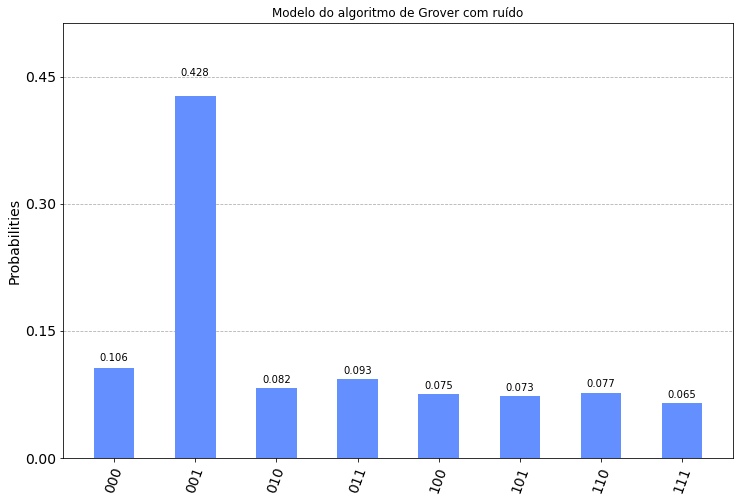

In [65]:
# Execute noisy simulation and get counts
result_noise = execute(circuito, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_noise = result_noise.get_counts(circuito)
plot_histogram(counts_noise, title="Modelo do algoritmo de Grover com ruído",figsize = (12,8))

Comparando os resultados

In [66]:
print(counts_sim)

{'000': 9, '001': 965, '111': 9, '100': 5, '101': 14, '011': 9, '010': 9, '110': 4}


In [67]:
print(counts_noise)

{'001': 438, '010': 84, '000': 109, '101': 75, '100': 77, '110': 79, '111': 67, '011': 95}


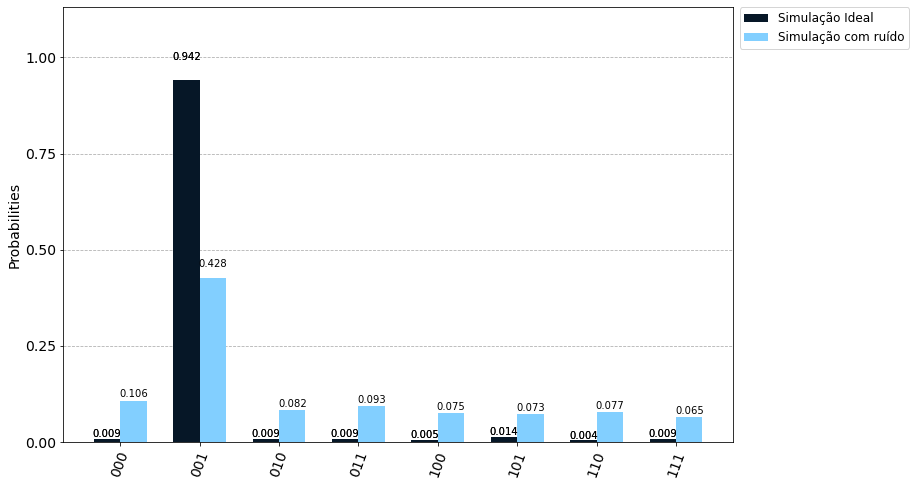

In [68]:
plot_histogram([counts_sim,counts_noise], legend= ['Simulação Ideal','Simulação com ruído'], 
               color=['#061727','#82cfff'],figsize = (12,8))

### Aplicar optimizações

#### Optimização de nível 1

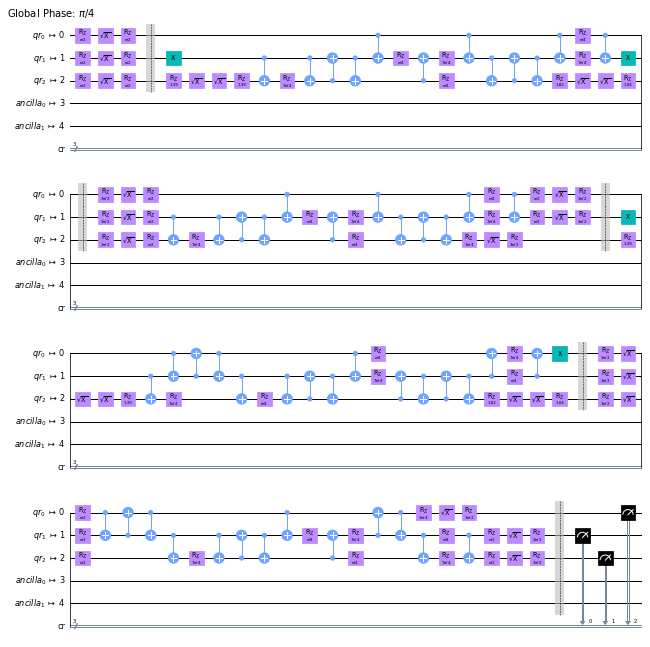

In [69]:
from qiskit.compiler import transpile
from qiskit.visualization import plot_circuit_layout

circuito_real = transpile(circuito, backend=backend_device)
circuito_real.draw(output='mpl', scale=0.5)

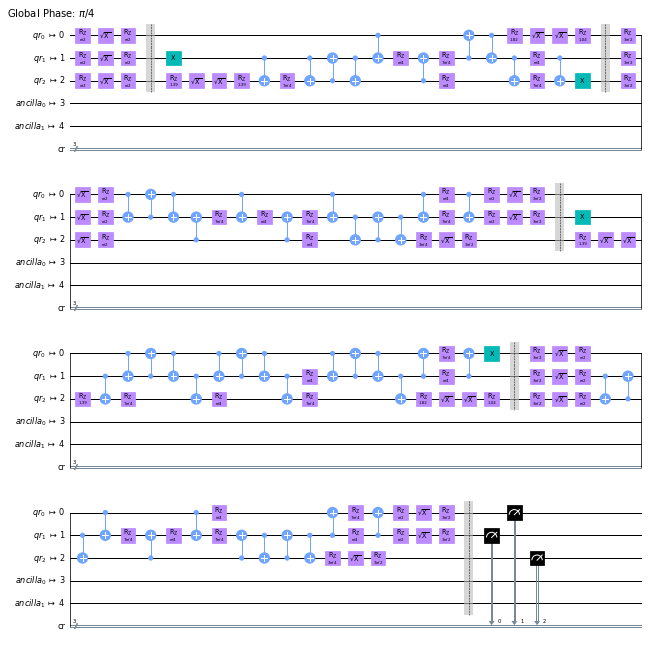

In [70]:
circuito_optimizado_1 = transpile(circuito, backend=backend_device, optimization_level=1)
circuito_optimizado_1.draw(output='mpl', scale=0.5)

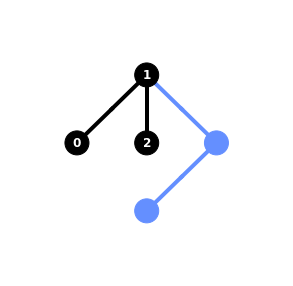

In [71]:
plot_circuit_layout(circuito_optimizado_1, backend_device)

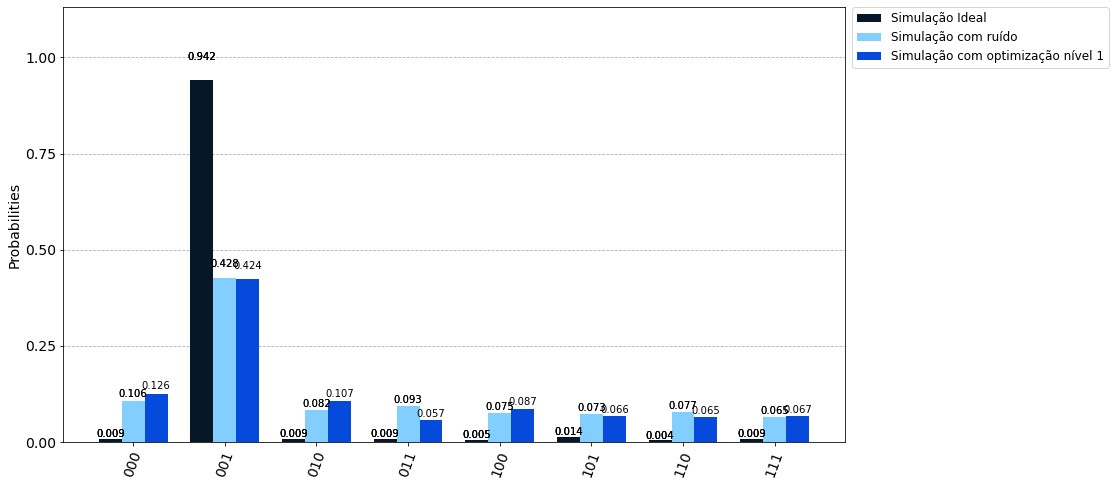

In [72]:
result_optimizado_1 = execute(circuito_optimizado_1, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_optimizado_1 = result_optimizado_1.get_counts(circuito_optimizado_1)
plot_histogram([counts_sim,counts_noise,counts_optimizado_1], 
               legend= ['Simulação Ideal','Simulação com ruído','Simulação com optimização nível 1'], 
               color=['#061727','#82cfff','#054ada'],figsize = (14,8))

#### Optimização de nível 2

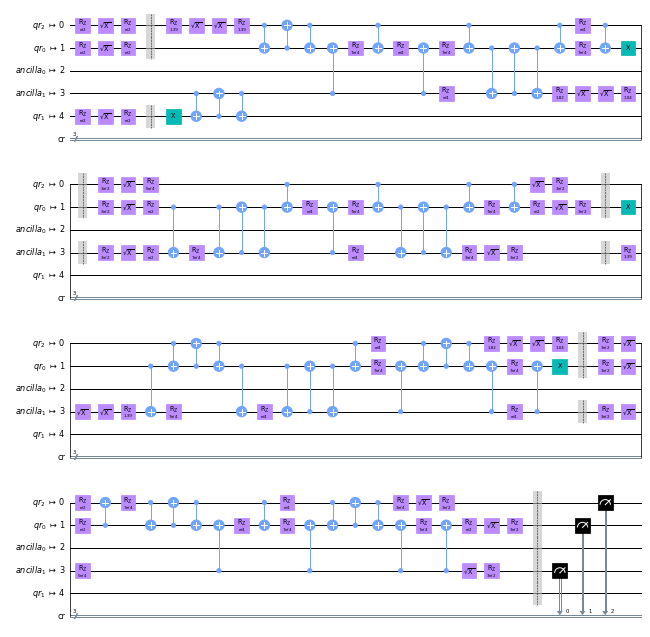

In [73]:
circuito_optimizado_2 = transpile(circuito, backend=backend_device, optimization_level=2)
circuito_optimizado_2.draw(output='mpl', scale=0.5)

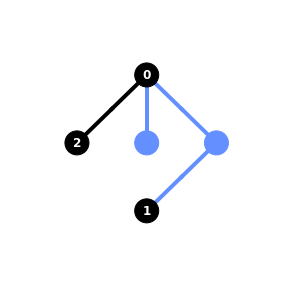

In [74]:
plot_circuit_layout(circuito_optimizado_2, backend_device)

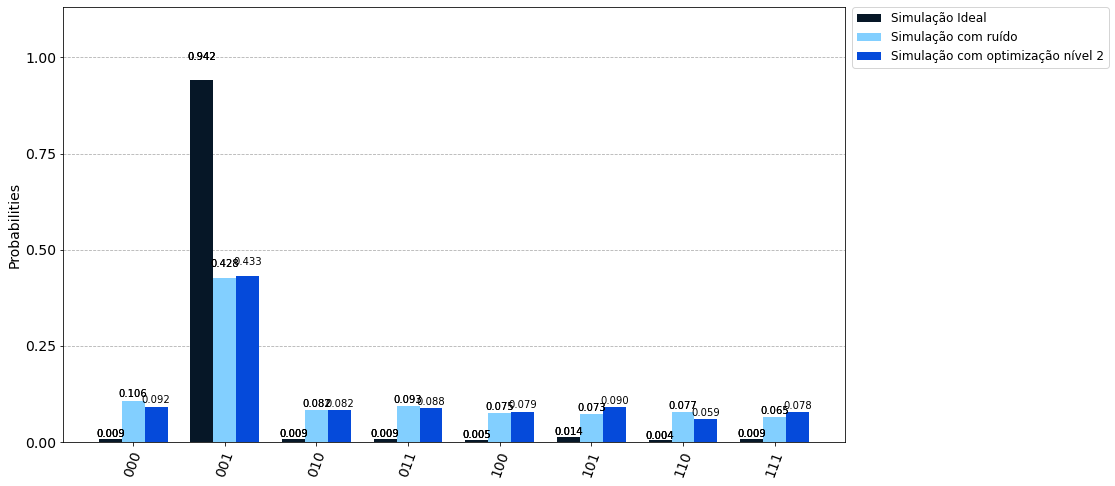

In [75]:
result_optimizado_2 = execute(circuito_optimizado_2, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_optimizado_2 = result_optimizado_2.get_counts(circuito_optimizado_2)
plot_histogram([counts_sim,counts_noise,counts_optimizado_2], 
               legend= ['Simulação Ideal','Simulação com ruído','Simulação com optimização nível 2'], 
               color=['#061727','#82cfff','#054ada'],figsize = (14,8))

#### Optimização de nível 3

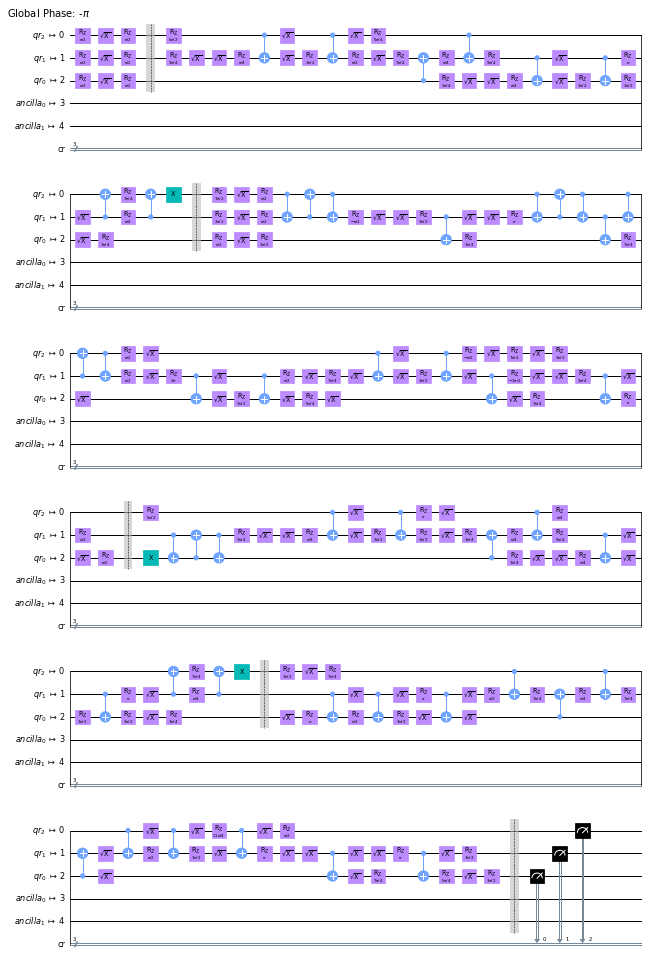

In [76]:
circuito_optimizado_3 = transpile(circuito, backend=backend_device, optimization_level=3)
circuito_optimizado_3.draw(output='mpl', scale=0.5)

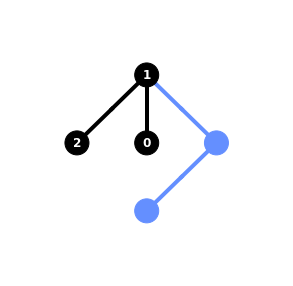

In [77]:
plot_circuit_layout(circuito_optimizado_3, backend_device)

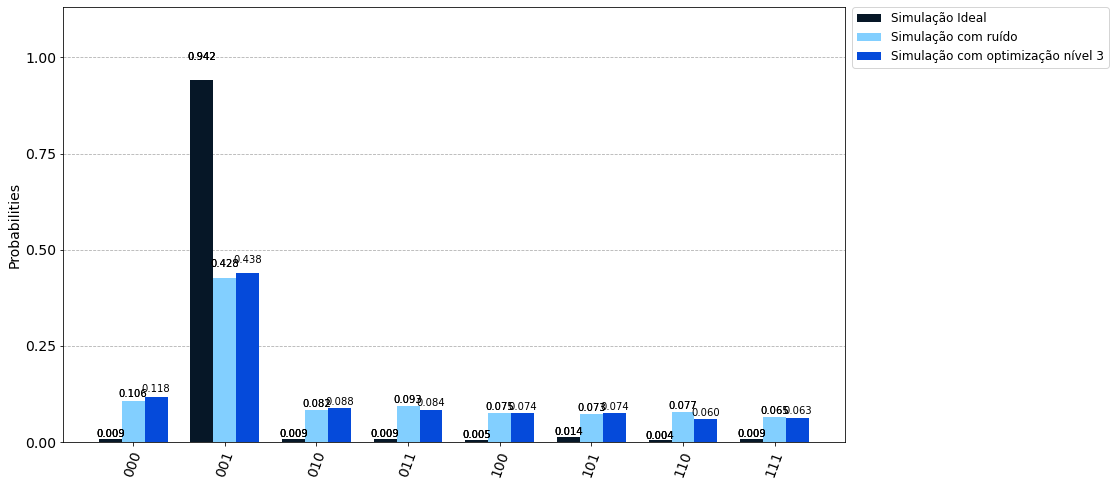

In [78]:
result_optimizado_3 = execute(circuito_optimizado_3, backend, 
                       noise_model=noise_model,
                       coupling_map=coupling_map,
                       basis_gates=basis_gates).result()

counts_optimizado_3 = result_optimizado_3.get_counts(circuito_optimizado_3)
plot_histogram([counts_sim,counts_noise,counts_optimizado_3], 
               legend= ['Simulação Ideal','Simulação com ruído','Simulação com optimização nível 3'], 
               color=['#061727','#82cfff','#054ada'],figsize = (14,8))

### Conclusões

Podemos desta forma concluir que a melhor optimização será a de nível 3 visto que foi a que nos deu melhores resultados

 ## 3. Execution in an IBM Q backend.

3.1.
<br>
Setup inicial

In [79]:
backend_device = least_busy(backends_list)
print("Running on current least busy device: ", backend_device)

Running on current least busy device:  ibmqx2


3.2.
<br>
Executar na máquina real

In [80]:
%qiskit_job_watcher

Accordion(children=(VBox(layout=Layout(max_width='710px', min_width='710px')),), layout=Layout(max_height='500…

<IPython.core.display.Javascript object>

In [81]:
job_r = execute(circuito, backend_device, shots=shots)
jobID_r = job_r.job_id()
print('JOB ID: {}'.format(jobID_r))

JOB ID: 60bd51fa25cc6e825465d984


3.3.
<br>
Receber os resultados

In [82]:
job_get=backend_device.retrieve_job("60bd51fa25cc6e825465d984")
result_r = job_get.result()
counts_run = result_r.get_counts()

3.4.
<br>
Colocando os resultados Ideais e os obtidos no despositivo real lado a lado, conseguimos notar bastante diferença nos resultados, sendo isto fruto dos diversos erros dos computadores quânticos.

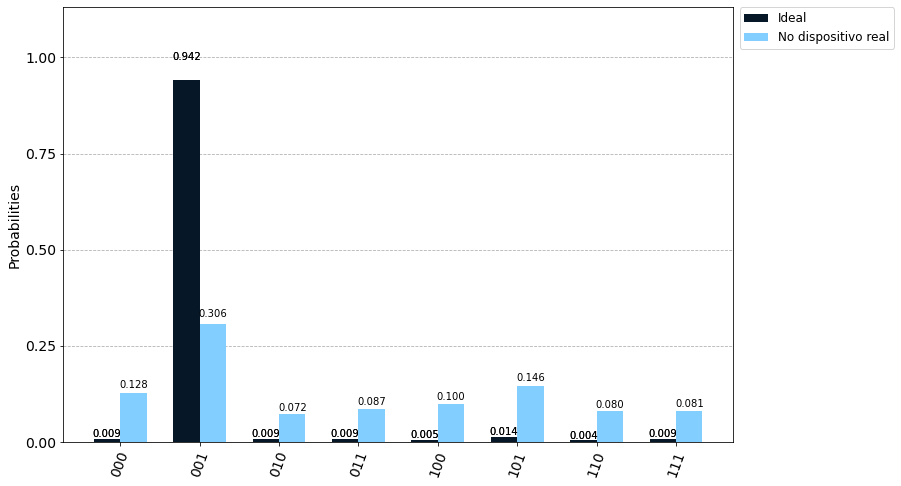

In [83]:
plot_histogram([counts_sim,counts_run ], legend=['Ideal' , 'No dispositivo real'], color=['#061727','#82cfff'],figsize = (12,8))

 ## 4. Mitigation of Error with Ignis

In [84]:
# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)

4.1
<br>
Começamos por gerar circuitos de calibração.
<br>
Como queremos medir 3 qubits precisamos de $2^3 = 8$ circuitos de calibração

In [85]:
qr = QuantumRegister(3)
meas_calibs, state_labels = complete_meas_cal(qubit_list=[0,1,2], qr=qr, circlabel='mcal')

In [86]:
state_labels

['000', '001', '010', '011', '100', '101', '110', '111']

4.2
<br>
Se não existe ruído no dispositivo a matriz de calibração deve ser a identidade $8 \times 8$.

In [87]:
job_ignis = execute(meas_calibs, backend=backend_device, shots=shots)

jobID_run_ignis = job_ignis.job_id()

print('JOB ID: {}'.format(jobID_run_ignis))

JOB ID: 60bd5219b454d02204aa7a6b


In [88]:
job_get=backend_device.retrieve_job("60bd5219b454d02204aa7a6b")
cal_results = job_get.result()

### Achar a Matriz de calibração

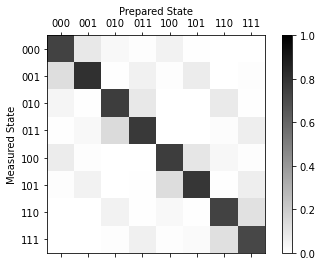

In [89]:
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
meas_fitter.plot_calibration()

In [90]:
print("Fidelidade média medida: %f" % meas_fitter.readout_fidelity())

Fidelidade média medida: 0.760132


### Aplicar a calibração

In [91]:
meas_filter = meas_fitter.filter

mitigated_results = meas_filter.apply(result_r)
mitigated_counts = mitigated_results.get_counts()

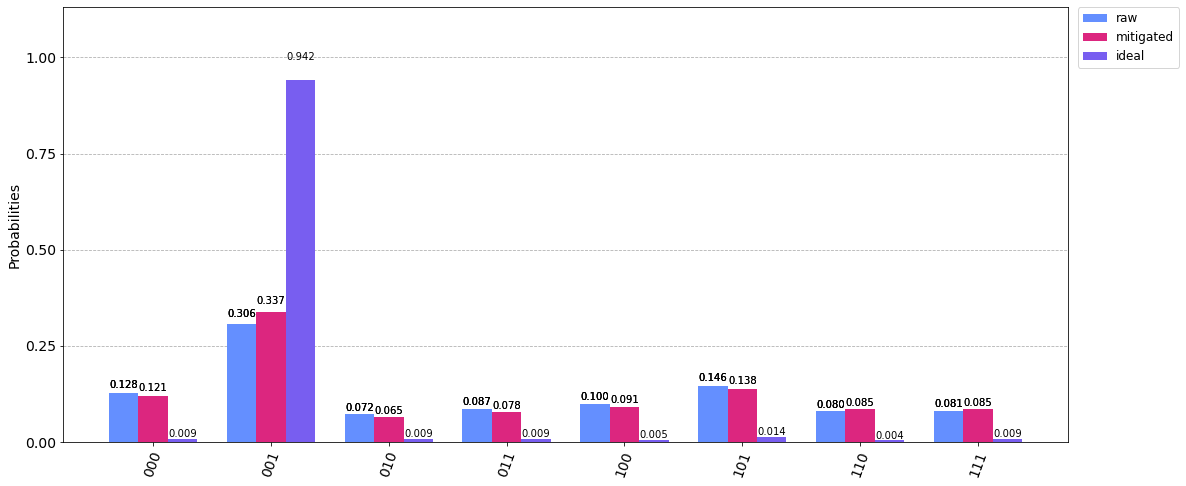

In [92]:
plot_histogram([counts_run, mitigated_counts, counts_sim], legend=['raw', 'mitigated', 'ideal'],figsize = (18,8))

    Desta forma podemos concluir que a calibração Ignis melhorou os resultados.